In [2]:
import os
import sys
import pulp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Set up the directories
code_dir = os.getcwd()
project_dir = os.path.dirname(code_dir)
data_dir = os.path.join(project_dir, 'data')

# Read data
nutritional_requirements_df = pd.read_excel(os.path.join(data_dir, 'female_nutritional_requirements.xlsx'), index_col=0, header=0)
food_items_cost_co2_intake_df = pd.read_excel(os.path.join(data_dir, 'food_items_cost_co2_intake.xlsx'), index_col=2, header=0)
food_items_nutritional_composition_df = pd.read_excel(os.path.join(data_dir, 'food_items_nutritional_composition.xlsx'), index_col=2, header=0)
food_groups_mean_intake_df = pd.read_excel(os.path.join(data_dir, 'food_groups_mean_intake.xlsx'), index_col=1, header=0)

# Data for the model
nutrients = list(nutritional_requirements_df.index)
nutrients.remove('Pantothenic acid (mg)') # Laking data for Pantothenic acid in the nutritional composition

food_items = list(food_items_cost_co2_intake_df.index)
food_groups = list(food_items_cost_co2_intake_df['Food group'].unique())
food_groups.remove('Condiments') # Remove condiments from the food groups as suggest Koenen 

# Nutritional requirements dictionary (min and max intake)
nutritional_requirements = {nutrient : {} for nutrient in nutrients}
for nutrient in nutrients:
    rni_value = nutritional_requirements_df.loc[nutrient, 'RNI']
    nutritional_requirements[nutrient]['min intake'] = np.float64(0) if pd.isna(rni_value) else rni_value
    ul_value = nutritional_requirements_df.loc[nutrient, 'UL']
    nutritional_requirements[nutrient]['max intake'] = 10*rni_value if pd.isna(ul_value) else ul_value

# Food items data dictionary (cost, co2, min and max intake)
food_items_data = {food_item : {} for food_item in food_items}
for food_item in food_items:
    food_item_dict = {}
    food_item_dict['cost'] = food_items_cost_co2_intake_df.loc[food_item, 'Cost (KHR/g)']
    food_item_dict['co2'] = food_items_cost_co2_intake_df.loc[food_item, 'CO2e (Kg/1000g)']
    food_item_dict['min intake'] = food_items_cost_co2_intake_df.loc[food_item, 'Min Intake (g)']
    food_item_dict['max intake'] = food_items_cost_co2_intake_df.loc[food_item, 'Max Intake (g)']
    food_items_data[food_item] = food_item_dict

# Food items nutrients dictionary (nutritional composition)
food_items_nutrients = {food_item : {} for food_item in food_items}
for food_item in food_items:
    food_item_dict = {}
    for nutrient in nutrients:
        food_item_dict[nutrient] = food_items_nutritional_composition_df.loc[food_item, nutrient]
    food_items_nutrients[food_item] = food_item_dict

# Food groups dictionary (mean intake and food items list)
food_groups_data = {food_group : {} for food_group in food_groups}
for food_group in food_groups:
    food_group_dict = {}
    food_group_dict['mean intake'] = food_groups_mean_intake_df.loc[food_group, 'Mean Intake (g)']
    food_group_dict['food items'] = list(food_items_cost_co2_intake_df[food_items_cost_co2_intake_df['Food group'] == food_group].index)
    food_groups_data[food_group] = food_group_dict

In [3]:
import pulp

# Create the model
model = pulp.LpProblem('FoodBasketThreeObjectivesLP', pulp.LpMinimize)

# Variables
x = pulp.LpVariable.dicts('x', food_items, lowBound=0, cat='Continuous') # Amount of each food item
zlow = pulp.LpVariable.dicts('zlow', food_groups, lowBound=0, cat='Continuous') # Deviation below the current mean intake of each food group
zup = pulp.LpVariable.dicts('zup', food_groups, lowBound=0, cat='Continuous') # Deviation above the current mean intake of each food group

# Objectives (defined as variables)
f1 = pulp.LpVariable('Total Cost', lowBound=0, cat='Continuous') # Minimize cost
f2 = pulp.LpVariable('Total inadherence', lowBound=0, cat='Continuous') # Maximize energy intake
f3 = pulp.LpVariable('Total CO2e', lowBound=0, cat='Continuous') # Minimize CO2 emissions

# Objective function (defined as constraints, to be minimized)
model += f1 == pulp.lpSum([x[food_item] * food_items_data[food_item]['cost'] for food_item in food_items]) # Eq 5.1
model += f2 == pulp.lpSum([100 * (zlow[food_group] + zup[food_group]) / food_groups_data[food_group]['mean intake'] for food_group in food_groups]) # Eq 5.2
model += f3 == pulp.lpSum([(1/1000) * x[food_item] * food_items_data[food_item]['co2'] for food_item in food_items]) # Eq 5.3

# Constraints
for nutrient in nutrients:
    model += pulp.lpSum([(1/100) * x[food_item] * food_items_nutrients[food_item][nutrient] for food_item in food_items]) >= nutritional_requirements[nutrient]['min intake'] # Eq 5.4
    model += pulp.lpSum([(1/100) * x[food_item] * food_items_nutrients[food_item][nutrient] for food_item in food_items]) <= nutritional_requirements[nutrient]['max intake'] # Eq 5.5

for food_group in food_groups:
    model += pulp.lpSum([x[food_item] for food_item in food_groups_data[food_group]['food items']]) + zlow[food_group] >= food_groups_data[food_group]['mean intake'] # Eq 5.6
    model += pulp.lpSum([x[food_item] for food_item in food_groups_data[food_group]['food items']]) - zup[food_group] <= food_groups_data[food_group]['mean intake'] # Eq 5.7

for food_item in food_items:
    model += x[food_item] >= food_items_data[food_item]['min intake'] # Eq 5.8
    model += x[food_item] <= food_items_data[food_item]['max intake'] # Eq 5.9

model += f1 <= 5000

# List of objectives and variables
variables = [x[food_item] for food_item in food_items] + \
            [zlow[food_group] for food_group in food_groups] + \
            [zup[food_group] for food_group in food_groups]

objectives = [f1, f2, f3]

weights1 = [1, 0.000001, 0.000001]
weights2 = [0.000001, 1, 0.000001]
weights3 = [0.000001, 0.000001, 1]
weights = weights3

model += weights[0] * f1 + weights[1] * f2 + weights[2] * f3
model.solve()

# Results
print('Objective values:')
print('Total cost:', pulp.value(f1))
print('Total deviation from current consumption:', pulp.value(f2))
print('Total CO2e:', pulp.value(f3))

print('\nFood items:')
for food_item in food_items:
    if x[food_item].varValue > 0:
        print(food_item, x[food_item].varValue)

Objective values:
Total cost: 5000.0
Total deviation from current consumption: 4338.1066
Total CO2e: 0.3477536

Food items:
Noodles, egg, dry, enriched 208.48381
Bean, kidney, dried, raw 214.42
Leaf, amaranth, spiney, raw 90.003611
Pineapple, ripe 37.098151
Duck, liver, raw 20.585327
Fish, barb, pool, with bones, eyes included, raw 19.453304
Oil, vegetable 75.845576


In [4]:
# Importing from the src directory
from src.MOLP import MOLP, Solution
from src.NBI import NBI, plot_NBI_2D, plot_NBI_3D

#----------------------------------------------
# Parameters
#----------------------------------------------
num_ref_points = 10

#----------------------------------------------
# Run the NBI algorithm
#----------------------------------------------
# Create the MOLP object
molp = MOLP(model, objectives, variables)
# Compute the individual optima for all objectives
sol = molp.compute_all_individual_optima()


# Create the NBI object (inherits from MOLP and adds the NBI algorithm)
nbi = NBI(model, objectives, variables)
# Compute NBI algorithm
nbi.NBI_algorithm(num_ref_points)

NBI algorithm completed.


{'q1': <src.MOLP.Solution at 0x22eb92bd3d0>,
 'q2': <src.MOLP.Solution at 0x22eb92bdb80>,
 'q3': <src.MOLP.Solution at 0x22eb92be1e0>,
 'q4': <src.MOLP.Solution at 0x22eb92ef110>,
 'q5': <src.MOLP.Solution at 0x22eb934f440>,
 'q6': <src.MOLP.Solution at 0x22eb92ef410>,
 'q7': <src.MOLP.Solution at 0x22eb92bfc80>,
 'q8': <src.MOLP.Solution at 0x22eb934ff80>,
 'q9': <src.MOLP.Solution at 0x22eb92ef530>,
 'q10': <src.MOLP.Solution at 0x22eb9373ef0>,
 'q11': <src.MOLP.Solution at 0x22eb936d790>,
 'q12': <src.MOLP.Solution at 0x22eb935b1d0>,
 'q13': <src.MOLP.Solution at 0x22eb9373950>,
 'q14': <src.MOLP.Solution at 0x22eb936e300>,
 'q15': <src.MOLP.Solution at 0x22eb92bf140>,
 'q16': <src.MOLP.Solution at 0x22eb93822d0>,
 'q17': <src.MOLP.Solution at 0x22e97bbd250>,
 'q18': <src.MOLP.Solution at 0x22eb9373290>,
 'q19': <src.MOLP.Solution at 0x22eb8fefe90>,
 'q20': <src.MOLP.Solution at 0x22eb935b710>,
 'q21': <src.MOLP.Solution at 0x22eb93c7aa0>,
 'q22': <src.MOLP.Solution at 0x22eb934fe00

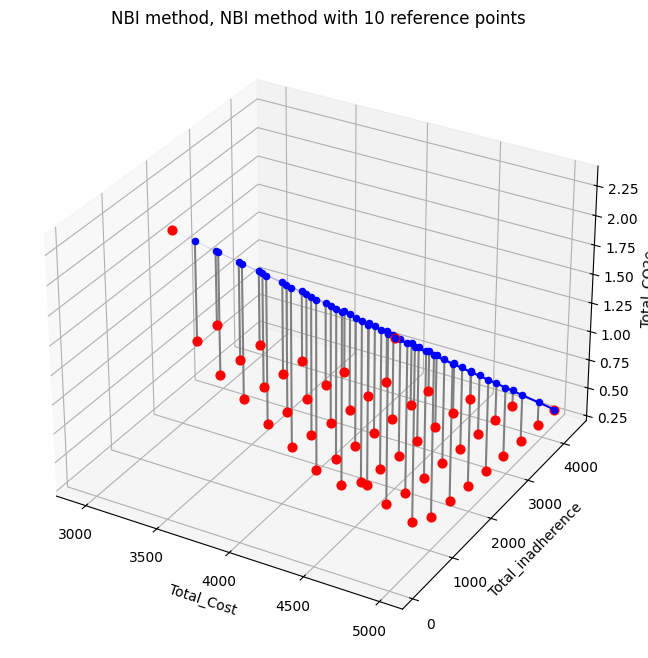

In [5]:
plot_NBI_3D(nbi)
